In [1]:
from hst_cos_lsf import *

In [2]:
# These will be important directories for the Notebook

cwd = Path(".")
datadir = cwd / "data"
outputdir = cwd / "output"
plotsdir = cwd / "output" / "plots"

# Make the directories if they don't exist
datadir.mkdir(exist_ok=True), outputdir.mkdir(exist_ok=True), plotsdir.mkdir(exist_ok=True)


(None, None, None)

In [3]:
# Search for obs_id of files, generate data product list
pl = Observations.get_product_list(
    Observations.query_criteria(obs_id="LCRS51010")
)  

download = Observations.download_products(
    pl[pl["productSubGroupDescription"] == "X1DSUM"],  # filter and download searched files
    download_dir=str(datadir),
)

# Give the program the path to your downloaded data
fuvFile = download["Local Path"][0]



INFO: Found cached file data/mastDownload/HST/lcrs51010/lcrs51010_x1dsum.fits with expected size 1811520. [astroquery.query]


In [4]:
fuvHeader0 = fits.getheader(fuvFile, ext=0)  # Select the primary header
print(f"For the file {fuvFile}, the relevant parameters are: ")
param_dict = {}  # Make a dict to store what you find here

for hdrKeyword in [
    "DETECTOR",
    "OPT_ELEM",
    "LIFE_ADJ",
    "CENWAVE",
    "DISPTAB",
]:  # Print out the relevant values
    try:  # For DISPTAB
        value = fuvHeader0[hdrKeyword].split("$")[1]  # Save the key/value pairs to the dictionary
        param_dict[hdrKeyword] = value                # DISPTAB needs the split here
    except:  # For other params
        value = fuvHeader0[hdrKeyword]  # Save the key/value pairs to the dictionary
        param_dict[hdrKeyword] = value
    print(f"{hdrKeyword} = {value}")  # Print the key/value pairs

For the file data/mastDownload/HST/lcrs51010/lcrs51010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 3
CENWAVE = 1291
DISPTAB = 52j2117ml_disp.fits


In [5]:
# We'll pass that fetch function the parameters we determined earlier
# This "unpacked argument" phrasing works because of the order in which we added the params to the dict
LSF_file_name, disptab_path = fetch_files(*list(param_dict.values()))

NameError: name 'datadir' is not defined

In [10]:
def read_lsf(filename):
    # This is the table of all the LSFs: called "lsf"
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    if "nuv_" in filename:  # If its an NUV file, header starts 1 line later
        ftype = "nuv"

    else:  # assume its an FUV file
        ftype = "fuv"
    hs = 0
    lsf = Table.read(filename, format="ascii", header_start=hs)

    # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
    # middle pixel of the lsf is considered zero ; center is relative zero
    pix = np.arange(len(lsf)) - len(lsf) // 2  # integer division to yield whole pixels

    # the column names returned as integers.
    lsf_wvlns = np.array([int(float(k)) for k in lsf.keys()])

    return lsf, pix, lsf_wvlns

In [11]:
lsf, pix, lsf_wvlns = read_lsf(str(datadir / LSF_file_name))

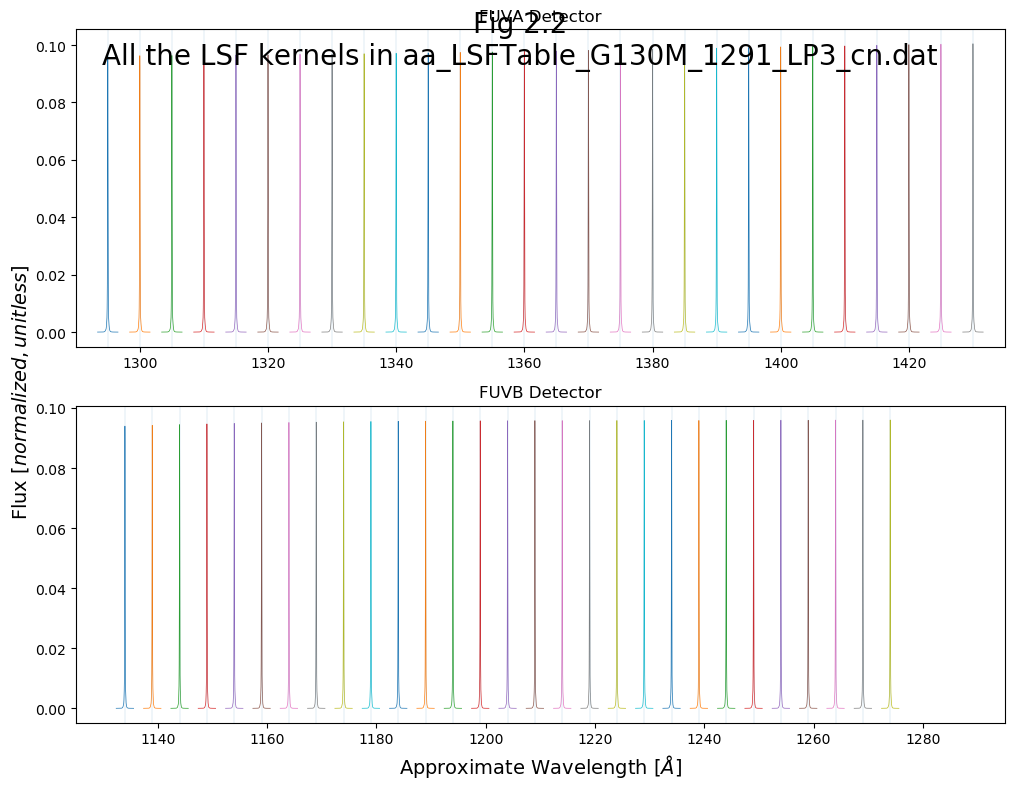

In [18]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8), dpi=100)

# Loop through the lsf kernels
for i, col in enumerate(lsf.colnames):
    line_wvln = int(col)  # central position
    contents = lsf[col].data  # actual shape

    if line_wvln < 1291:  # split into the FUVB segment
        xrange = 0.00997 * pix + line_wvln  # ROUGHLY convert pix to wvln
        ax1.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax1.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line

    elif line_wvln > 1291:  # split into the FUVA segment
        xrange = 0.00997 * pix + line_wvln  # ROUGHLY convert pix to wvln
        ax0.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax0.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line

# Format the figure
ax0.set_xlim(1290, 1435)
ax1.set_xlim(1125, 1295)
# Add labels, titles and text
fig.suptitle(f"Fig 2.2\nAll the LSF kernels in {LSF_file_name}", fontsize=20)
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax1.set_xlabel("Approximate Wavelength [$\AA$]", size=14)
fig.text(s="Flux [$normalized,unitless$]", x=-0.01, y=0.35, rotation="vertical", size=14)
plt.tight_layout()

# Save the figure
plt.savefig(str(plotsdir / "allKernels.png"), bbox_inches="tight")

In [19]:
def get_disp_params(disptab, cenwave, segment, x=[]):
    """
    Helper function to redefine_lsf(). Reads through a DISPTAB file and gives relevant\
    dispersion relationship/wavelength solution over input pixels.
    Parameters:
    disptab (str): Path to your DISPTAB file.
    cenwave (str): Cenwave for calculation of dispersion relationship.
    segment (str): FUVA or FUVB?
    x (list): Range in pixels over which to calculate wvln with dispersion relationship (optional).
    Returns:
    disp_coeff (list): Coefficients of the relevant polynomial dispersion relationship
    wavelength (list; if applicable): Wavelengths corresponding to input x pixels 
    """
    with fits.open(disptab) as d:
        wh_disp = np.where(
            (d[1].data["cenwave"] == cenwave)
            & (d[1].data["segment"] == segment)
            & (d[1].data["aperture"] == "PSA")
        )[0]
        disp_coeff = d[1].data[wh_disp]["COEFF"][0] # 0 is needed as this returns nested list [[arr]]
        d_tv03 = d[1].data[wh_disp]["D_TV03"]  # Offset from WCA to PSA in Thermal Vac. 2003 data
        d_orbit = d[1].data[wh_disp]["D"]  # Current offset from WCA to PSA

    delta_d = d_tv03 - d_orbit

    if len(x):  # If given a pixel range, build up a polynomial wvln solution pix -> λ
        wavelength = np.polyval(p=disp_coeff[::-1], x=np.arange(16384))
        return disp_coeff, wavelength
    else:  # If x is empty:
        return disp_coeff

In [20]:
def redefine_lsf(lsf_file, cenwave, disptab, detector="FUV"):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)\
    which can then be used by convolve_lsf() and re-bins the kernels.
    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    detector (str): FUV or NUV?
    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """

    if detector == "FUV":
        xfull = np.arange(16384)

        # Read in the dispersion relationship here for the segments
        ### FUVA is simple
        disp_coeff_a, wavelength_a = get_disp_params(disptab, cenwave, "FUVA", x=xfull)
        ### FUVB isn't taken for cenwave 1105, nor 800:
        if (cenwave != 1105) & (cenwave != 800):
            disp_coeff_b, wavelength_b = get_disp_params(
                disptab, cenwave, "FUVB", x=xfull)
        elif cenwave == 1105:
            # 1105 doesn't have an FUVB so set it to something arbitrary and clearly not real:
            wavelength_b = [-99.0, 0.0]

        # Get the step size info from the FUVA 1st order dispersion coefficient
        step = disp_coeff_a[1]

        # Read in the lsf file
        lsf, pix, w = read_lsf(lsf_file)

        # take median spacing between original LSF kernels
        deltaw = np.median(np.diff(w))

        lsf_array = [np.array(lsf[key]) for key in lsf.keys()]
        if (deltaw < len(pix) * step * 2):  # resamples if the spacing of the original LSF wvlns is too narrow
            # this is all a set up of the bins we want to use
            # The wvln difference between kernels of the new LSF should be about twice their width
            new_deltaw = round(len(pix) * step * 2.0)  
            new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
            new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns

            # populating the lsf with the proper bins
            new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate
            for i, current_w in enumerate(new_w):
                dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
                lsf_index = np.argmin(dist)
                orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
                new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
        else:
            new_lsf = lsf
            new_w = w
        return new_lsf, new_w, step

    elif detector == "NUV":
        xfull = np.arange(1024)
        # Read in the dispersion relationship here for the segments
        disp_coeff_a, wavelength_a = get_disp_params(disptab, cenwave, "NUVA", x=xfull)
        disp_coeff_b, wavelength_b = get_disp_params(disptab, cenwave, "NUVB", x=xfull)
        disp_coeff_c, wavelength_c = get_disp_params(disptab, cenwave, "NUVC", x=xfull)

        # Get the step size info from the NUVB 1st order dispersion coefficient
        step = disp_coeff_b[1]

        # Read in the lsf file
        lsf, pix, w = read_lsf(lsf_file)

        # take median spacing between original LSF kernels
        deltaw = np.median(np.diff(w))

        lsf_array = [np.array(lsf[key]) for key in lsf.keys()]

        # this section is a set up of the new bins we want to use:
        new_deltaw = round(len(pix) * step * 2.0)  # The wvln difference between kernels of the new LSF should be about twice their width
        new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
        new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns

        # populating the lsf with the proper bins
        new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate
        for i, current_w in enumerate(new_w):
            dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
            lsf_index = np.argmin(dist)
            orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
            new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
        return new_lsf, new_w, step

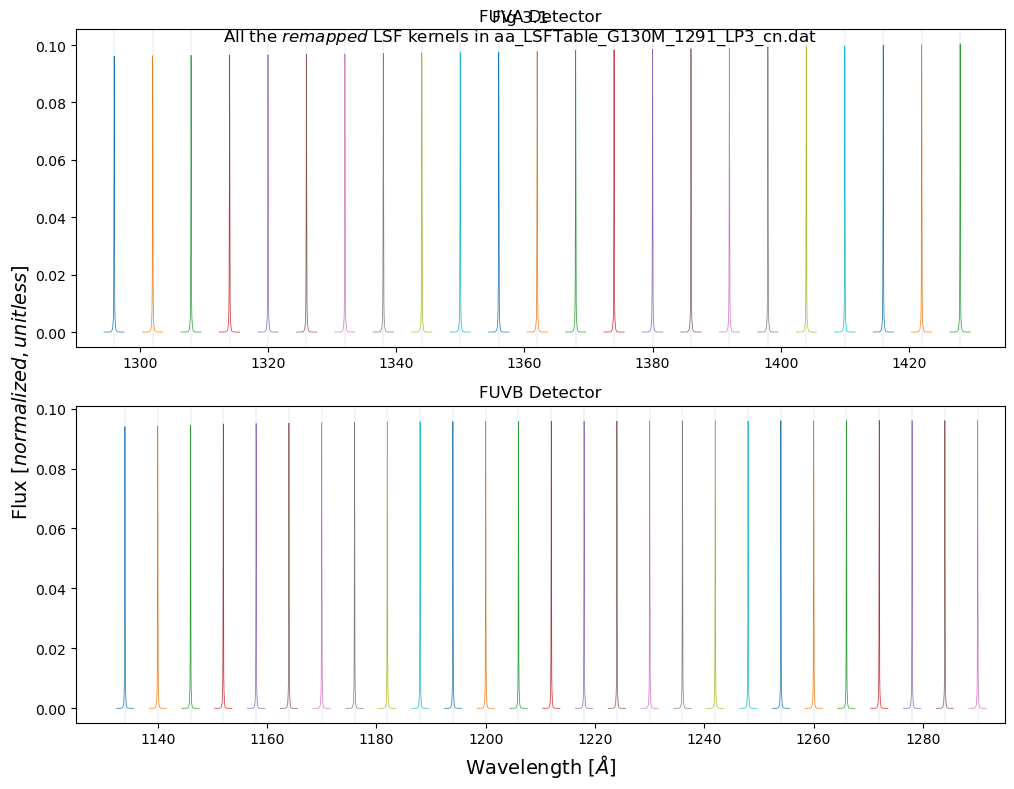

In [21]:
# Generate the redefined lsf for the plot
new_lsf, new_w, step = redefine_lsf(
    str(datadir / LSF_file_name),
    param_dict["CENWAVE"],
    str(datadir / param_dict["DISPTAB"]),
)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8), dpi=100)

# Loop through the new remapped lsf kernels
for i, col in enumerate(new_w):
    line_wvln = int(col)  # central position
    contents = new_lsf[:, i]  # actual shape
    if line_wvln < 1291:  # split into the FUVB segment
        xrange = new_w[i] + pix * step  # ROUGHLY convert pix to wvln
        ax1.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax1.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line
    elif line_wvln > 1291:  # split into the FUVA segment
        xrange = new_w[i] + pix * step  # ROUGHLY convert pix to wvln
        ax0.plot(xrange, contents, linewidth=0.5)  # Plot the kernel
        ax0.axvline(line_wvln, linewidth=0.1)  # plot the LSF wvln as a faded line

# Add labels, titles and text
fig.suptitle(f"Fig 3.1\nAll the $remapped$ LSF kernels in {LSF_file_name}\n")
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax0.set_xlim(1290, 1435)
ax1.set_xlim(1125, 1295)

ax1.set_xlabel("Wavelength [$\AA$]", size=14)
fig.text(
    s="Flux [$normalized,unitless$]", x=-0.01, y=0.35, rotation="vertical", size=14
)

# format and save the figure
plt.tight_layout()
plt.savefig(str(plotsdir / "allKernels_new.png"), bbox_inches="tight")

In [22]:
def convolve_lsf(wavelength, spec, cenwave, lsf_file, disptab, detector="FUV"):
    """
    Main function; Convolves an input spectrum - i.e. template or STIS spectrum - with the COS LSF.
    Parameters:
    wavelength (list or array): Wavelengths of the spectrum to convolve.
    spec (list or array): Fluxes or intensities of the spectrum to convolve.
    cenwave (str): Cenwave for calculation of dispersion relationship
    lsf_file (str): Path to your LSF file
    disptab (str): Path to your DISPTAB file
    detector (str) : Assumes an FUV detector, but you may specify 'NUV'.
    Returns:
    wave_cos (numpy.ndarray): Wavelengths of convolved spectrum.!Different length from input wvln
    final_spec (numpy.ndarray): New LSF kernel's LSF wavelengths.!Different length from input spec
    """
    # First calls redefine to get right format of LSF kernels
    new_lsf, new_w, step = redefine_lsf(lsf_file, cenwave, disptab, detector=detector)

    # sets up new wavelength scale used in the convolution
    nstep = round((max(wavelength) - min(wavelength)) / step) - 1
    wave_cos = min(wavelength) + np.arange(nstep) * step

    # resampling onto the input spectrum's wavelength scale
    interp_func = interp1d(wavelength, spec)  # builds up interpolated function from input spectrum
    spec_cos = interp_func(wave_cos)  # builds interpolated initial spectrum at COS' wavelength scale for convolution
    final_spec = interp_func(wave_cos)  # Initializes final spectrum to the interpolated input spectrum

    for i, w in enumerate(new_w):  # Loop through the redefined LSF kernels
        # First need to find the boundaries of each kernel's "jurisdiction": where it applies
        # The first and last elements need to be treated separately
        if i == 0:  # First kernel
            diff_wave_left = 500
            diff_wave_right = (new_w[i + 1] - w) / 2.0
        elif i == len(new_w) - 1:  # Last kernel
            diff_wave_right = 500
            diff_wave_left = (w - new_w[i - 1]) / 2.0
        else:  # All other kernels
            diff_wave_left = (w - new_w[i - 1]) / 2.0
            diff_wave_right = (new_w[i + 1] - w) / 2.0

        # splitting up the spectrum into slices around the redefined LSF kernel wvlns
        # will apply the kernel corresponding to that chunk to that region of the spectrum - its "jurisdiction"
        chunk = np.where(
            (wave_cos < w + diff_wave_right) & (wave_cos >= w - diff_wave_left)
        )[0]
        if len(chunk) == 0:
            # off the edge, go to the next chunk
            continue

        current_lsf = new_lsf[:, i]  # selects the current kernel

        if len(chunk) >= len(
            current_lsf
        ):  # Makes sure that the kernel is smaller than the chunk
            final_spec[chunk] = convolve(
                spec_cos[chunk],
                current_lsf,  # Applies the actual convolution
                boundary="extend",
                normalize_kernel=True,
            )

    return wave_cos, final_spec  # Remember, not the same length as input spectrum data!